In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from resnet_cifar10 import resnet_20, resnet_32, resnet_44, resnet_56, resnet_110

In [2]:
# 학습 및 테스트용 CIFAR-10 데이터셋 로드
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Class 개수와 이미지 크기 지정
NUM_CLASSES = 10            # CIFAR-10 Dataset 은 10개의 class 를 가지고 있음
IMG_HEIGHT = 32             # CIFAR-10 Dataset 의 이미지 크기 32x32x3
IMG_WIDTH = 32

# Epoch 횟수와 batch size, learning rate, dropout ratio 지정
EPOCHS = 200                 # 학습 반복 횟수 지정
BATCH_SIZE = 100            # 학습에 사용할 mini-batch 크기
LEARNING_RATE = 0.001       # Optimizer 에 사용할 learning rate

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [3]:
# One-hot encoding 형태로 label 데이터 변경
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

print(y_train.shape, y_test.shape)

# ImageDataGenerator pipeline 을 이용한 Data augmentation
# 학습용 데이터셋을 augmentation 하기 위한 ImageDataGenerator pipeline
datagen = ImageDataGenerator(
            featurewise_center=True,               # 각 이미지의 평균값에서 전체 데이터셋의 평균값을 빼서 분포의 평균을 0에 가깝게 만듦
            featurewise_std_normalization=True,    # 평균이 0이고 분산이 1인 정규 분포를 따르도록 정규화
            horizontal_flip=True,                  # random horizontal flip
            width_shift_range=0.125,               # 좌/우로 이미지를 이동시켜 학습 데이터 늘림(0.125 : 전체 가로 크기의 12.5% 범위 내)
            height_shift_range=0.125,              # 상/하로 이미지를 이동시켜 학습 데이터 늘림(0.125 : 전체 세로 크기의 12.5% 범위 내)
            validation_split=0.2)                  # validation 에 사용할 데이터 비율(20%)

# 테스트용 데이터셋을 augmentation 하기 위한 ImageDataGenerator pipeline
test_datagen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True)

# featurewise_center / featurewise_std_normalization 적용
datagen.fit(x_train)
test_datagen.fit(x_test)

(50000, 10) (10000, 10)


In [4]:
# ResNet-20 모델 생성
model = resnet_20(NUM_CLASSES)

# 학습에 사용할 SGD optimizer 및 loss function 생성
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
losses = tf.keras.losses.CategoricalCrossentropy()

# 모델 컴파일(optimizer, loss 지정)
model.compile(optimizer=optimizer,
              loss=losses,
              metrics=['acc'])

In [5]:
# Learning rate scheduler 함수
def lr_scheduler(epoch) :
    # epoch이 진행됨에 따라 learning rate를 조절함
    learning_rate = LEARNING_RATE
    if epoch >= 80 :
        learning_rate = LEARNING_RATE * 0.1
    if epoch >= 120 :
        learning_rate = LEARNING_RATE * 0.01
    return learning_rate

# Keras 에서 제공하는 LearningRateScheduler를 통해 callback 생성
lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
   
# Checkpoint 저장을 위한 callback
# TRAINED_MODEL_PATH 에 'val_acc' 기준으로 최대값이 갱신될 때마다 저장하도록 구현
save_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='trained_model\checkpoint',
                monitor='val_acc', verbose=1, save_best_only=True,
                save_weights_only=False, mode='max', save_freq='epoch')

# 필요한 callback 을 list 로 지정
callback_list = [lr, save_callback]

history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, subset='training'),
                    # 학습에 사용할 데이터 : 미리 만들어둔 ImageDataGenerator pipeline에 x_train, y_train 입력하여 사용
                    # subset = 'training' 으로 학습용 데이터라는 것을 pipeline에 알려주어야함
                   validation_data=datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
                    # 검증에 사용할 데이터 : 미리 만들어둔 ImageDataGenerator pipeline에 x_train, y_train 입력하여 사용
                    # subset = 'validation' 으로 검증용 데이터라는 것을 pipeline에 알려주어야함
                    epochs=EPOCHS,              # epoch 횟수 입력
                    shuffle=True,               # 매 epoch 학습 시작 전 데이터셋 무작위로 배치
                    callbacks=[callback_list])  # 매 epoch이 종료될 때 호출할 callback 함수 지정



Epoch 1/200
399/400 [============================>.] - ETA: 0s - loss: 1.8776 - acc: 0.3146
Epoch 00001: val_acc improved from -inf to 0.36860, saving model to trained_model\checkpoint
400/400 [==============================] - 22s 54ms/step - loss: 1.8768 - acc: 0.3149 - val_loss: 1.7100 - val_acc: 0.3686
Epoch 2/200
400/400 [==============================] - ETA: 0s - loss: 1.5749 - acc: 0.4215
Epoch 00002: val_acc improved from 0.36860 to 0.42960, saving model to trained_model\checkpoint
400/400 [==============================] - 21s 51ms/step - loss: 1.5749 - acc: 0.4215 - val_loss: 1.5561 - val_acc: 0.4296
Epoch 3/200
400/400 [==============================] - ETA: 0s - loss: 1.4547 - acc: 0.4679
Epoch 00003: val_acc improved from 0.42960 to 0.45460, saving model to trained_model\checkpoint
400/400 [==============================] - 21s 53ms/step - loss: 1.4547 - acc: 0.4679 - val_loss: 1.5033 - val_acc: 0.4546
Epoch 4/200
400/400 [==============================] - ETA: 0s - loss:

Epoch 29/200
400/400 [==============================] - ETA: 0s - loss: 0.6306 - acc: 0.7781
Epoch 00029: val_acc improved from 0.74170 to 0.75240, saving model to trained_model\checkpoint
400/400 [==============================] - 20s 51ms/step - loss: 0.6306 - acc: 0.7781 - val_loss: 0.7278 - val_acc: 0.7524
Epoch 30/200
399/400 [============================>.] - ETA: 0s - loss: 0.6154 - acc: 0.7833
Epoch 00030: val_acc did not improve from 0.75240
400/400 [==============================] - 20s 50ms/step - loss: 0.6150 - acc: 0.7835 - val_loss: 0.7654 - val_acc: 0.7342
Epoch 31/200
399/400 [============================>.] - ETA: 0s - loss: 0.6026 - acc: 0.7905
Epoch 00031: val_acc did not improve from 0.75240
400/400 [==============================] - 20s 50ms/step - loss: 0.6027 - acc: 0.7906 - val_loss: 0.7714 - val_acc: 0.7338
Epoch 32/200
399/400 [============================>.] - ETA: 0s - loss: 0.5937 - acc: 0.7908
Epoch 00032: val_acc improved from 0.75240 to 0.76440, saving m

Epoch 59/200
399/400 [============================>.] - ETA: 0s - loss: 0.3891 - acc: 0.8639
Epoch 00059: val_acc did not improve from 0.79860
400/400 [==============================] - 20s 50ms/step - loss: 0.3888 - acc: 0.8640 - val_loss: 0.6646 - val_acc: 0.7812
Epoch 60/200
399/400 [============================>.] - ETA: 0s - loss: 0.3816 - acc: 0.8636
Epoch 00060: val_acc did not improve from 0.79860
400/400 [==============================] - 20s 50ms/step - loss: 0.3813 - acc: 0.8637 - val_loss: 0.6246 - val_acc: 0.7932
Epoch 61/200
399/400 [============================>.] - ETA: 0s - loss: 0.3741 - acc: 0.8682
Epoch 00061: val_acc improved from 0.79860 to 0.80120, saving model to trained_model\checkpoint
400/400 [==============================] - 20s 51ms/step - loss: 0.3741 - acc: 0.8682 - val_loss: 0.6073 - val_acc: 0.8012
Epoch 62/200
399/400 [============================>.] - ETA: 0s - loss: 0.3754 - acc: 0.8675
Epoch 00062: val_acc did not improve from 0.80120
400/400 [====

Epoch 89/200
399/400 [============================>.] - ETA: 0s - loss: 0.2291 - acc: 0.9212
Epoch 00089: val_acc did not improve from 0.84110
400/400 [==============================] - 20s 51ms/step - loss: 0.2290 - acc: 0.9213 - val_loss: 0.5018 - val_acc: 0.8332
Epoch 90/200
399/400 [============================>.] - ETA: 0s - loss: 0.2320 - acc: 0.9181
Epoch 00090: val_acc did not improve from 0.84110
400/400 [==============================] - 20s 50ms/step - loss: 0.2318 - acc: 0.9182 - val_loss: 0.4959 - val_acc: 0.8375
Epoch 91/200
399/400 [============================>.] - ETA: 0s - loss: 0.2262 - acc: 0.9211
Epoch 00091: val_acc did not improve from 0.84110
400/400 [==============================] - 20s 50ms/step - loss: 0.2262 - acc: 0.9212 - val_loss: 0.5053 - val_acc: 0.8367
Epoch 92/200
399/400 [============================>.] - ETA: 0s - loss: 0.2283 - acc: 0.9211
Epoch 00092: val_acc improved from 0.84110 to 0.84240, saving model to trained_model\checkpoint
400/400 [====

400/400 [==============================] - 21s 52ms/step - loss: 0.2084 - acc: 0.9272 - val_loss: 0.4923 - val_acc: 0.8431
Epoch 120/200
399/400 [============================>.] - ETA: 0s - loss: 0.2093 - acc: 0.9280
Epoch 00120: val_acc did not improve from 0.84310
400/400 [==============================] - 20s 51ms/step - loss: 0.2094 - acc: 0.9280 - val_loss: 0.4963 - val_acc: 0.8416
Epoch 121/200
400/400 [==============================] - ETA: 0s - loss: 0.2040 - acc: 0.9287
Epoch 00121: val_acc did not improve from 0.84310
400/400 [==============================] - 20s 50ms/step - loss: 0.2040 - acc: 0.9287 - val_loss: 0.4932 - val_acc: 0.8371
Epoch 122/200
399/400 [============================>.] - ETA: 0s - loss: 0.2048 - acc: 0.9287
Epoch 00122: val_acc did not improve from 0.84310
400/400 [==============================] - 20s 50ms/step - loss: 0.2047 - acc: 0.9287 - val_loss: 0.4919 - val_acc: 0.8353
Epoch 123/200
400/400 [==============================] - ETA: 0s - loss: 0.2

Epoch 150/200
399/400 [============================>.] - ETA: 0s - loss: 0.2003 - acc: 0.9297
Epoch 00150: val_acc did not improve from 0.84560
400/400 [==============================] - 20s 50ms/step - loss: 0.2001 - acc: 0.9298 - val_loss: 0.5006 - val_acc: 0.8375
Epoch 151/200
399/400 [============================>.] - ETA: 0s - loss: 0.2016 - acc: 0.9296
Epoch 00151: val_acc did not improve from 0.84560
400/400 [==============================] - 20s 50ms/step - loss: 0.2015 - acc: 0.9297 - val_loss: 0.4959 - val_acc: 0.8372
Epoch 152/200
399/400 [============================>.] - ETA: 0s - loss: 0.1980 - acc: 0.9316
Epoch 00152: val_acc did not improve from 0.84560
400/400 [==============================] - 20s 50ms/step - loss: 0.1980 - acc: 0.9316 - val_loss: 0.4973 - val_acc: 0.8397
Epoch 153/200
399/400 [============================>.] - ETA: 0s - loss: 0.2021 - acc: 0.9288
Epoch 00153: val_acc did not improve from 0.84560
400/400 [==============================] - 20s 50ms/ste

Epoch 181/200
399/400 [============================>.] - ETA: 0s - loss: 0.1995 - acc: 0.9312
Epoch 00181: val_acc did not improve from 0.84780
400/400 [==============================] - 20s 50ms/step - loss: 0.1995 - acc: 0.9312 - val_loss: 0.4900 - val_acc: 0.8428
Epoch 182/200
399/400 [============================>.] - ETA: 0s - loss: 0.1971 - acc: 0.9315
Epoch 00182: val_acc did not improve from 0.84780
400/400 [==============================] - 20s 50ms/step - loss: 0.1973 - acc: 0.9313 - val_loss: 0.5058 - val_acc: 0.8402
Epoch 183/200
399/400 [============================>.] - ETA: 0s - loss: 0.2027 - acc: 0.9290
Epoch 00183: val_acc did not improve from 0.84780
400/400 [==============================] - 20s 50ms/step - loss: 0.2027 - acc: 0.9290 - val_loss: 0.4916 - val_acc: 0.8415
Epoch 184/200
399/400 [============================>.] - ETA: 0s - loss: 0.1993 - acc: 0.9299
Epoch 00184: val_acc did not improve from 0.84780
400/400 [==============================] - 20s 50ms/ste

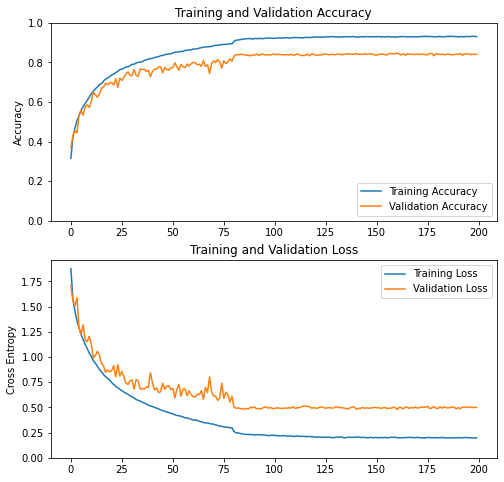

In [6]:
# Training accuracy 및 validation accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

# Training loss 및 validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# matplotlib 를 이용하여 accuracy 및 loss 출력
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [7]:
# Test 데이터를 이용한 학습 모델 검증
test_loss, test_acc = model.evaluate(
                        test_datagen.flow(x_test, y_test, batch_size=1),
                        verbose=1)
print('Test Loss : {:.4f}, Test Accuracy : {:.2f}%'.format(test_loss, 100.*test_acc))

10000/10000 [==============================] - 50s 5ms/step - loss: 0.5281 - acc: 0.8404: 1s
Test Loss : 0.5281, Test Accuracy : 84.04%
